# Water Management Model Notebook
This notebook demonstrates a machine learning model to predict water usage and control motors based on forecasted needs.

## Importing Required Libraries

In [195]:
import logging
from tabulate import tabulate
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from datetime import datetime

## Load Data Function

In [196]:
def load_data(file_path):
    """Load dataset from a CSV file."""
    return pd.read_csv(file_path)

## Create Sequences Function

In [197]:
def create_sequences(data, time_steps=24):
    sequences, targets = [], []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
        targets.append(data[i + time_steps])
    return np.array(sequences), np.array(targets)

## Build CNN Model Function

In [198]:
def build_cnn_model(input_shape):
    """Build a 1D CNN model for water usage prediction."""
    model = Sequential([
        Conv1D(32, 3, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 3, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(100, activation='relu'),
        Dropout(0.2),
        Dense(1)  # Output layer
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

## Train CNN Model Function

In [199]:
def train_cnn_model(X_train, y_train, X_test, y_test):
    cnn_model = build_cnn_model((X_train.shape[1], 1))
    history = cnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))
    return cnn_model, history

## Train Other Models Function

In [200]:
def train_other_models(X_train, y_train):
    # Reshape X_train to 2D for compatibility with the other models
    X_train_2d = X_train.reshape(X_train.shape[0], X_train.shape[1])
    
    rf_model = RandomForestRegressor(n_estimators=100).fit(X_train_2d, y_train)
    xgb_model = XGBRegressor(n_estimators=100).fit(X_train_2d, y_train)
    
    return rf_model, xgb_model

## Ensemble Predictions Function

In [201]:
def ensemble_predictions(cnn_model, rf_model, xgb_model, X_test):
    cnn_preds = cnn_model.predict(X_test).flatten()
    rf_preds = rf_model.predict(X_test)
    xgb_preds = xgb_model.predict(X_test)
    return np.column_stack((cnn_preds, rf_preds, xgb_preds))

## Final Model Training Function

In [202]:
def train_final_model(stacked_features, y_test):
    final_model = LinearRegression().fit(stacked_features, y_test)
    return final_model

## Model Evaluation Function

In [203]:
def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}")
    return mse, mae

## Round Robin Allocator

In [204]:
def is_peak_hour():
    return 17 <= datetime.now().hour <= 20
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

# Round-robin scheduler with logging
def round_robin_scheduler(motors, water_levels, forecasted_needs, threshold=30):
    for motor_id in motors:
        if water_levels[motor_id] < forecasted_needs[motor_id] and not is_peak_hour():
            logging.info(f"Activating motor {motor_id}: Water level ({water_levels[motor_id]}%) below threshold for forecasted need ({forecasted_needs[motor_id]}%)")
            print(f"Activating motor {motor_id}")
        else:
            logging.info(f"Skipping motor {motor_id}: Current water level ({water_levels[motor_id]}%) adequate or peak hour active.")
            print(f"Skipping motor {motor_id}")


## Data Loading

In [205]:
# Load and prepare data
data = load_data('dataset.csv')
df = pd.DataFrame(data)
# print(df)
print(tabulate(df, headers='keys', tablefmt='grid'))
if 'water_usage' not in data.columns:
    raise ValueError("The dataset must contain a 'water_usage' column.")

+------+---------------------+------------+---------------+---------------------+---------------+--------------------+---------------+
|      | timestamp           |   house_id |   water_level |   power_consumption |   pump_status |   electricity_cost |   water_usage |
+======+=====================+============+===============+=====================+===============+====================+===============+
|    0 | 2024-10-01 00:00:00 |          1 |       41.6616 |                  27 |             1 |              15.41 |         32.17 |
+------+---------------------+------------+---------------+---------------------+---------------+--------------------+---------------+
|    1 | 2024-10-01 01:00:00 |          1 |       43.6003 |                  25 |             0 |              12.19 |         38.41 |
+------+---------------------+------------+---------------+---------------------+---------------+--------------------+---------------+
|    2 | 2024-10-01 02:00:00 |          1 |       33.53

## Train Test Split

In [206]:
sequences, targets = create_sequences(data['water_usage'].values)
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Train individual models

In [207]:
# Train individual models
cnn_model, history = train_cnn_model(X_train, y_train, X_test, y_test)
rf_model, xgb_model = train_other_models(X_train, y_train)

Epoch 1/50


c:\Projects\Water-consumption-Analysis\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 133.1633 - val_loss: 8.5956
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21.0790 - val_loss: 12.0913
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1152 - val_loss: 9.8272
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.2079 - val_loss: 8.5742
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.7528 - val_loss: 9.3034
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.9983 - val_loss: 8.5513
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.9740 - val_loss: 8.5204
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.6600 - val_loss: 11.2571
Epoch 9/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19.1101 - val_loss: 8.6804
Epoch 10/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17.2239 - val_loss: 9.4368
Epoch 11/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 18.5823 - val_loss: 8.5935
Epoch 12/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16.7686 - va

## Get predictions


In [208]:
# Get predictions
cnn_preds = cnn_model.predict(X_test).flatten()
rf_preds = rf_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))
xgb_preds = xgb_model.predict(X_test.reshape(X_test.shape[0], X_test.shape[1]))

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


## Evaluate individual models

In [209]:
metrics = {}
for model_name, preds in zip(['CNN', 'Random Forest', 'XGBoost'], [cnn_preds, rf_preds, xgb_preds]):
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    metrics[model_name] = {'MAE': mae, 'RMSE': rmse}
    evaluate_model(model_name, y_test, preds)

CNN - MSE: 8.95, MAE: 2.51
Random Forest - MSE: 8.13, MAE: 2.42
XGBoost - MSE: 9.12, MAE: 2.55


## Ensemble predictions

In [210]:
# Ensemble predictions
stacked_features = np.column_stack((cnn_preds, rf_preds, xgb_preds))
final_model = train_final_model(stacked_features, y_test)
ensemble_preds = final_model.predict(stacked_features)

## Evaluate ensemble


In [211]:
ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))
metrics['Ensemble'] = {'MAE': ensemble_mae, 'RMSE': ensemble_rmse}
evaluate_model('Ensemble', y_test, ensemble_preds)


Ensemble - MSE: 7.89, MAE: 2.40


(np.float64(7.890809978140665), np.float64(2.3960285729417286))

In [212]:
# Create a results DataFrame
results_df = pd.DataFrame(metrics).T
print(results_df)

                    MAE      RMSE
CNN            2.513807  2.991553
Random Forest  2.422998  2.852155
XGBoost        2.551162  3.020269
Ensemble       2.396029  2.809059


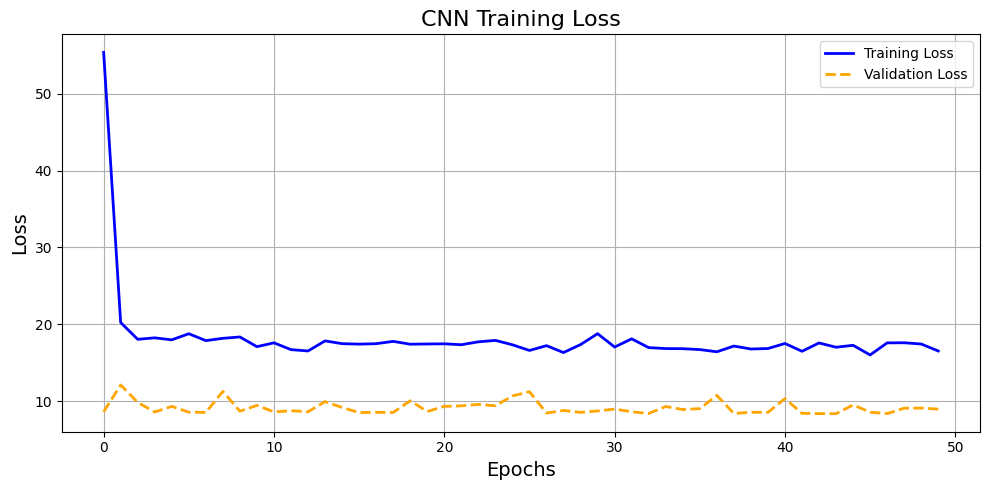

In [213]:
# Improved Training Loss Visualization
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
# If you have validation data, you could plot validation loss too:
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linestyle='--', linewidth=2)
plt.title('CNN Training Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Improved Actual vs. Predicted Values Plot

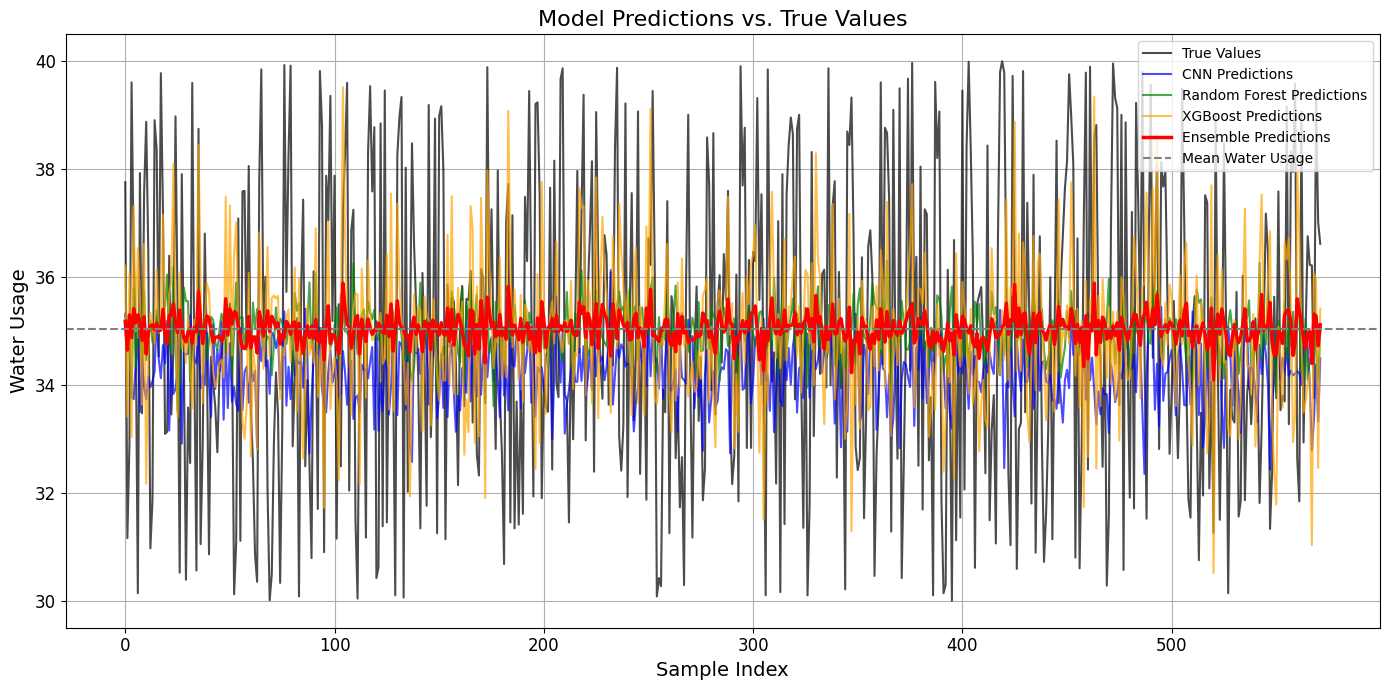

In [214]:

plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', alpha=0.7, color='black', linewidth=1.5)
plt.plot(cnn_preds, label='CNN Predictions', alpha=0.7, color='blue', linewidth=1.5)
plt.plot(rf_preds, label='Random Forest Predictions', alpha=0.7, color='green', linewidth=1.5)
plt.plot(xgb_preds, label='XGBoost Predictions', alpha=0.7, color='orange', linewidth=1.5)
plt.plot(ensemble_preds, label='Ensemble Predictions', color='red', linewidth=2.5)

plt.title('Model Predictions vs. True Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Water Usage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=np.mean(y_test), color='gray', linestyle='--', label='Mean Water Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Improved Bar Chart for Evaluation Metrics


<Figure size 1000x600 with 0 Axes>

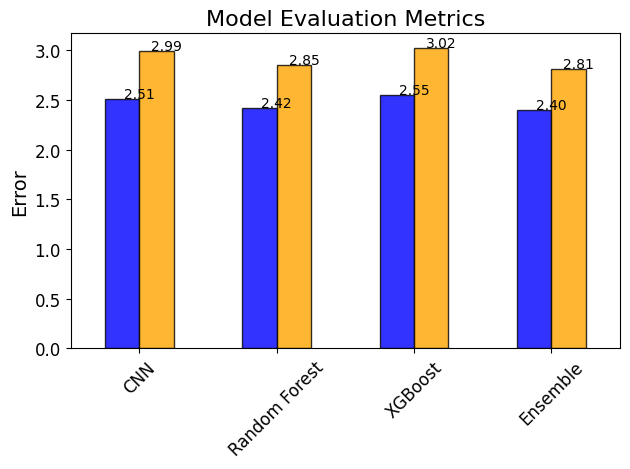

In [215]:
metrics_df = pd.DataFrame(metrics).T

plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', color=['blue', 'orange'], alpha=0.8, edgecolor='black', legend=False)
plt.title('Model Evaluation Metrics', fontsize=16)
plt.ylabel('Error', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Add value labels above the bars
for index, value in enumerate(metrics_df['MAE']):
    plt.text(index, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

for index, value in enumerate(metrics_df['RMSE']):
    plt.text(index + 0.2, value + 0.01, f'{value:.2f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()


## Improved Ensemble Predictions vs. True Values


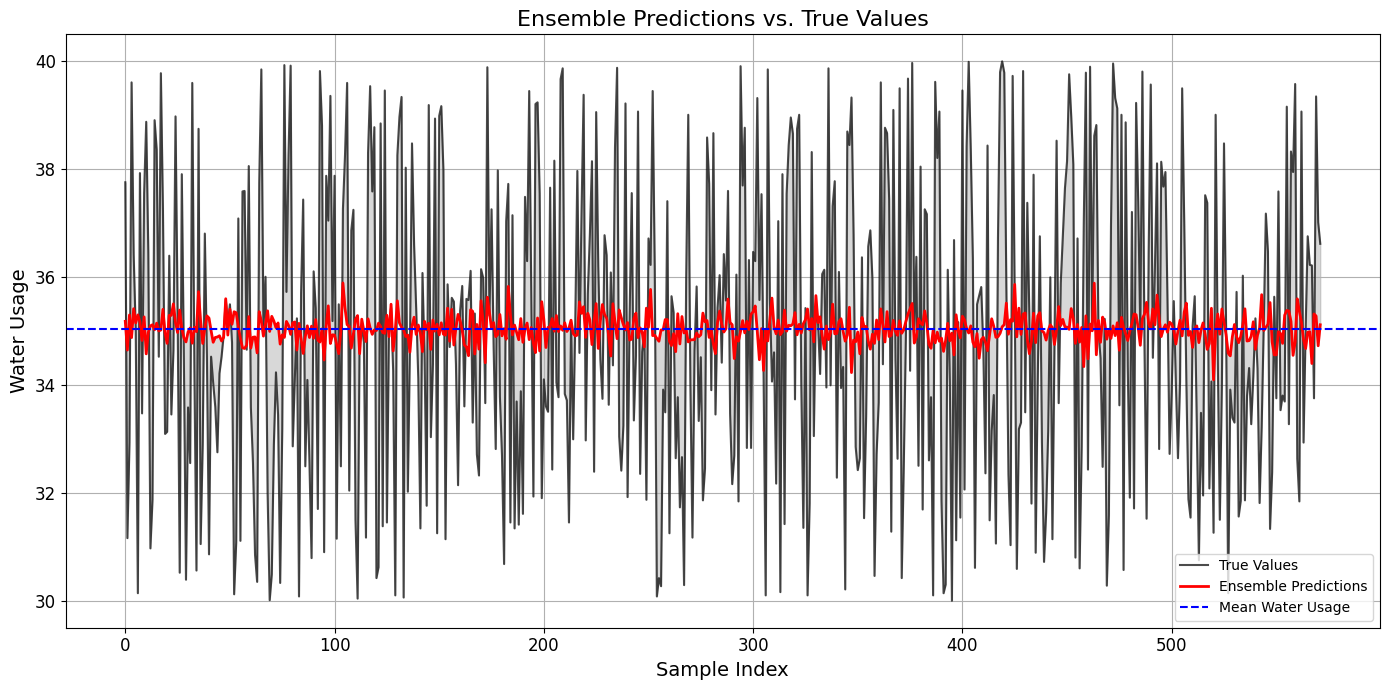

In [216]:
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='True Values', color='black', alpha=0.7, linewidth=1.5)
plt.plot(ensemble_preds, label='Ensemble Predictions', color='red', linewidth=2)

# Adding fill to show error margin
plt.fill_between(range(len(y_test)), y_test, ensemble_preds, color='gray', alpha=0.3)
plt.title('Ensemble Predictions vs. True Values', fontsize=16)
plt.xlabel('Sample Index', fontsize=14)
plt.ylabel('Water Usage', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=np.mean(y_test), color='blue', linestyle='--', label='Mean Water Usage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Round Robin scheduler

In [217]:
 # Motor scheduling demonstration
motors = [1, 2, 3]  # Example motor IDs
water_levels = {1: 25, 2: 40, 3: 30}  # Example water levels (%)
forecasted_needs = {1: 10, 2: 45, 3: 60}  # Example forecasted needs (%)
round_robin_scheduler(motors, water_levels, forecasted_needs)

2024-10-28 00:32:45,219 - Skipping motor 1: Current water level (25%) adequate or peak hour active.
2024-10-28 00:32:45,220 - Activating motor 2: Water level (40%) below threshold for forecasted need (45%)
2024-10-28 00:32:45,222 - Activating motor 3: Water level (30%) below threshold for forecasted need (60%)


Skipping motor 1
Activating motor 2
Activating motor 3
